# ts_aos_analysis

# AOS  DM-46763:  WET-007 Compare CWFS approaches with OR4 ComCam data 

For https://rubinobs.atlassian.net/browse/SITCOM-1149

Last verified to run 2024/10/24

Versions:

* lsst_distrib w_2024_37 (ext, cvmfs)

* ts_wep v11.5.2

Use AOS OR4 LsstComCamSim  data. It is in `embargo_or4` repository. The planner for observations was https://github.com/jmeyers314/aos_block_planner/blob/main/OR4.ipynb  

In this notebook we run ISR, donut detection and cutouts, and TIE / Danish Zernike retrieval. The main objective is to verify whether TIE / Danish provide similar fit results.


## Imports

In [2]:
from lsst.daf import butler as dafButler
import matplotlib.pyplot as plt 
from astropy.visualization import ZScaleInterval
import numpy as np
from astropy.table import Table
import itertools
from bokeh.palettes import viridis
from bokeh.plotting import figure, show
from bokeh.plotting import output_notebook

## Inspect the data

First, find out the range of data for the first OR4 night:

In [287]:
butler = dafButler.Butler('/repo/embargo')

In [295]:
butler = dafButler.Butler('/repo/embargo')
refs = list(butler.registry.queryDatasets('raw',  collections=['LSSTComCam/raw/all'],
                              where="instrument='LSSTComCam' and day_obs=20241024 and exposure.observation_type='cwfs'"
                             ).expanded())

exposure.RecordClass(instrument='LSSTComCam', id=2024102400075, day_obs=20241024, group='2024-10-25T03:36:54.070#2', physical_filter='r_03', obs_id='CC_O_20241024_000075', exposure_time=30.0, dark_time=30.4342, observation_type='cwfs', observation_reason='intra', seq_num=75, seq_start=75, seq_end=75, target_name='UNKNOWN', science_program='BLOCK-T60', tracking_ra=354.75817226415063, tracking_dec=-25.75848742150633, sky_angle=0.0, azimuth=277.4302137617038, zenith_angle=20.560503313865198, has_simulated=False, can_see_sky=True, timespan=Timespan(begin=astropy.time.Time(2460609.0, -0.34798986092209494, scale='tai', format='jd'), end=astropy.time.Time(2460609.0, -0.34763760416666667, scale='tai', format='jd')))

In [301]:
for ref in refs[:100]:
    print(ref.dataId.exposure.observation_type,  ref.dataId.detector.id, ref.dataId.exposure.observation_reason,  ref.dataId.exposure.seq_num,  ref.dataId.exposure.science_program)

cwfs 7 intra 75 BLOCK-T60
cwfs 0 extra 73 BLOCK-T60
cwfs 1 intra 72 BLOCK-T60
cwfs 5 extra 76 BLOCK-T60
cwfs 2 extra 73 BLOCK-T60
cwfs 4 extra 73 BLOCK-T60
cwfs 8 extra 73 BLOCK-T60
cwfs 6 extra 76 BLOCK-T60
cwfs 3 extra 73 BLOCK-T60
cwfs 3 intra 75 BLOCK-T60
cwfs 7 intra 72 BLOCK-T60
cwfs 4 intra 72 BLOCK-T60
cwfs 5 intra 72 BLOCK-T60
cwfs 3 intra 72 BLOCK-T60
cwfs 6 intra 72 BLOCK-T60
cwfs 2 intra 72 BLOCK-T60
cwfs 0 intra 72 BLOCK-T60
cwfs 8 intra 72 BLOCK-T60
cwfs 8 intra 75 BLOCK-T60
cwfs 1 intra 75 BLOCK-T60
cwfs 2 intra 75 BLOCK-T60
cwfs 5 intra 75 BLOCK-T60
cwfs 6 intra 75 BLOCK-T60
cwfs 4 intra 75 BLOCK-T60
cwfs 1 extra 73 BLOCK-T60
cwfs 6 extra 73 BLOCK-T60
cwfs 7 extra 73 BLOCK-T60
cwfs 5 extra 73 BLOCK-T60
cwfs 0 intra 75 BLOCK-T60
cwfs 8 extra 76 BLOCK-T60
cwfs 3 intra 78 BLOCK-T148
cwfs 4 intra 81 BLOCK-T148
cwfs 7 intra 81 BLOCK-T148
cwfs 3 intra 84 BLOCK-T148
cwfs 0 extra 85 BLOCK-T148
cwfs 2 extra 85 BLOCK-T148
cwfs 0 extra 88 BLOCK-T148
cwfs 8 intra 90 BLOCK-T148
cwfs

In [294]:
refs[0].dataId.exposure.observation_type = 'cwfs

exposure.RecordClass(instrument='LSSTComCam', id=2024102400001, day_obs=20241024, group='BT220_O_20241024_000001', physical_filter='r_03', obs_id='CC_O_20241024_000001', exposure_time=0.0, dark_time=0.0141869, observation_type='bias', observation_reason='comcam-daily-calibration', seq_num=1, seq_start=1, seq_end=1, target_name='AzEl', science_program='BLOCK-T220', tracking_ra=288.3390653915448, tracking_dec=-30.16286925082558, sky_angle=None, azimuth=328.0064803207103, zenith_angle=0.13123960468379892, has_simulated=False, can_see_sky=False, timespan=Timespan(begin=astropy.time.Time(2460608.0, 0.40548052079975694, scale='tai', format='jd'), end=astropy.time.Time(2460608.0, 0.4054806828703704, scale='tai', format='jd')))

In [3]:
butler = dafButler.Butler('embargo_or4')
len(list(butler.registry.queryDatasets('raw', collections=['LSSTComCamSim/defaults'],
                                        where= "instrument='LSSTComCamSim' and day_obs=20240625").expanded()))

INFO:botocore.credentials:Found credentials in shared credentials file: /home/s/scichris/.lsst/aws-credentials.ini


7758

Check how in this particular simulation the `observation_type` connects to `seq_num`: 

In [4]:
dataRefs = butler.registry.queryDatasets('raw', collections=['LSSTComCamSim/defaults'],
                                         where= "day_obs=20240625 and instrument='LSSTComCamSim'").expanded()

for ref in list(dataRefs)[58:80]:
    print(ref.dataId.exposure.id, ref.dataId.exposure.observation_type, ref.dataId.exposure.seq_num,
         ref.dataId.exposure.observation_reason, ref.dataId.exposure.science_program)
    

7024062500059 focus 59 focus BLOCK-278
7024062500060 focus 60 focus BLOCK-278
7024062500061 cwfs 61 intra_sens_cam_dz_-100um BLOCK-279
7024062500062 cwfs 62 extra_sens_cam_dz_-100um BLOCK-279
7024062500063 acq 63 infocus_sens_cam_dz_-100um BLOCK-279
7024062500064 cwfs 64 intra_sens_cam_dz_-75um BLOCK-279
7024062500065 cwfs 65 extra_sens_cam_dz_-75um BLOCK-279
7024062500066 acq 66 infocus_sens_cam_dz_-75um BLOCK-279
7024062500067 cwfs 67 intra_sens_cam_dz_-50um BLOCK-279
7024062500068 cwfs 68 extra_sens_cam_dz_-50um BLOCK-279
7024062500069 acq 69 infocus_sens_cam_dz_-50um BLOCK-279
7024062500070 cwfs 70 intra_sens_cam_dz_-25um BLOCK-279
7024062500071 cwfs 71 extra_sens_cam_dz_-25um BLOCK-279
7024062500072 acq 72 infocus_sens_cam_dz_-25um BLOCK-279
7024062500073 cwfs 73 intra_sens_cam_dz_0um BLOCK-279
7024062500074 cwfs 74 extra_sens_cam_dz_0um BLOCK-279
7024062500075 acq 75 infocus_sens_cam_dz_0um BLOCK-279
7024062500076 cwfs 76 intra_sens_cam_dz_25um BLOCK-279
7024062500077 cwfs 77 ext

Each intra/extra pair (`cwfs`) is followed by an in-focus exposure (`acq`). The first in each sequence is intra-focal, extra-focal, then in-focus.  All Zernikes are calculated based such intra/extra pair, and stored under the extra-focal seqNum (eg. 62). Thus showing Zk fit for seqNum 62, which used exposures with  seqNum 61 and 62.

How many datasets have `observation_type` of `cwfs`:

In [5]:
len(list(butler.registry.queryDatasets('raw', collections=['LSSTComCamSim/defaults'],
         where= "day_obs=20240625 and exposure.observation_type='cwfs' and instrument='LSSTComCamSim'").expanded()))


414

Run these through ISR pipeline:

    cd /sdf/group/rubin/shared/scichris/DM-46763_WET-007

    
    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q milano -g 1800 s3df --account rubin:developers
    

    bps submit site_bps.yaml \
    -b embargo_or4 \
    -i LSSTComCamSim/defaults \
    -o u/scichris/or4_night1_isr \
    -p lsstComCamSimPipelineISR.yaml \
    -d "day_obs=20240625 and exposure.observation_type='cwfs' and instrument='LSSTComCamSim'"



Check the ISR results:

In [88]:
butler = dafButler.Butler('embargo_or4')
dataRefs = butler.registry.queryDatasets('postISRCCD', collections=['u/scichris/or4_night1_isr']).expanded()
refs = []
for ref in dataRefs: 
    refs.append(ref)
print(len(refs))

414


In [262]:
dataRefs = butler.registry.queryDatasets('postISRCCD', collections=['u/scichris/or4_night1_isr'],
                                        where="instrument='LSSTComCamSim'  and exposure in (7024062500061)").expanded()

In [263]:
len(list(dataRefs))

9

In [264]:
list(dataRefs)

[DatasetRef(DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'LSSTComCamSim', detector: 0, exposure: 7024062500061, band: 'i', day_obs: 20240625, group: '2024-06-25T23:41:49.724#1', physical_filter: 'i_06'}, run='u/scichris/or4_night1_isr/20241018T003228Z', id=185dbe45-659c-4fd6-8335-bde931bd7215),
 DatasetRef(DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'LSSTComCamSim', detector: 1, exposure: 7024062500061, band: 'i', day_obs: 20240625, group: '2024-06-25T23:41:49.724#1', physical_filter: 'i_06'}, run='u/scichris/or4_night1_isr/20241018T003228Z', id=fd482a29-0313-4f8e-be1f-eec3cc3bd652),
 DatasetRef(DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'LSSTComCamSim', detector: 2, exposure: 7024062500061, band: 'i', day_obs: 20240625, group: '2024-06-25T23:41:49.724#

That shows that indeed all the `raw` datasets now are avaiable as `postISRCCD`. Show R22 postISRCCDs:

In [265]:
exps = [butler.get('postISRCCD', dataId=ref.dataId, collections=['u/scichris/or4_night1_isr']) for ref in list(dataRefs)]


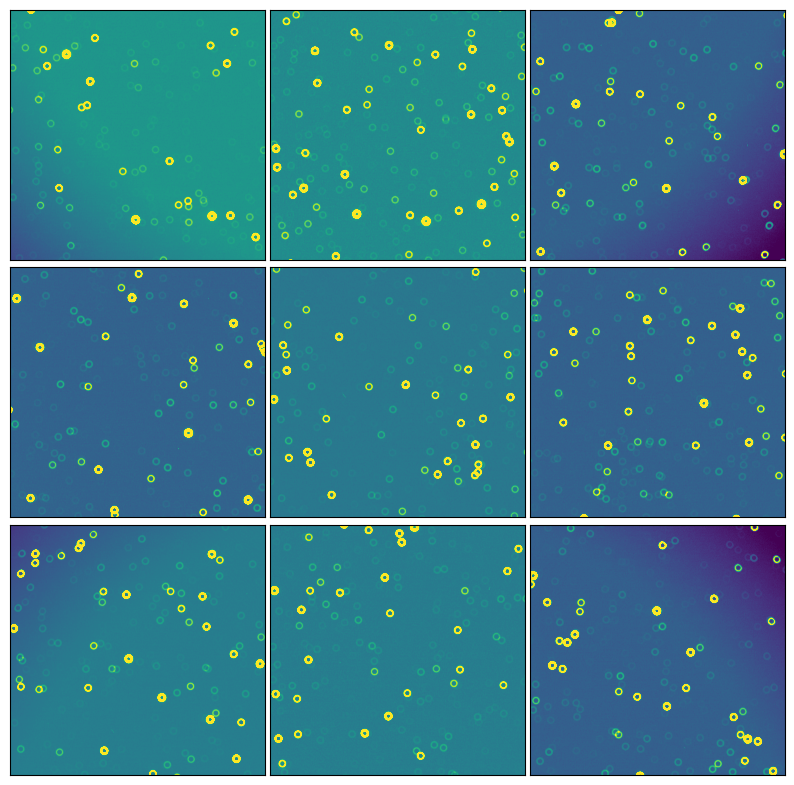

In [278]:

zscale = ZScaleInterval()

fig,axs = plt.subplots(3,3,figsize=(10,10))
ax = np.ravel(axs)
for i in range(len(exps)):
    exp=exps[i]
    d = exp.image.array
    vmin,vmax = zscale.get_limits(d)
    ax[i].imshow(d, vmin=vmin, vmax=vmax, origin='lower')
    #ax.set_title(f'{refs[0].dataId.exposure.id}, det {detId} ')
    #ax.set_xlabel('x [px]')
    #ax.set_ylabel('y [px]')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
fig.subplots_adjust(hspace=0.01, wspace=0.02)

Run donut detection and cutouts with `bps` 

    bps submit site_bps.yaml \
    -b embargo_or4 \
    -i u/scichris/or4_night1_isr \
    -o u/scichris/or4_night1_direct_stamps_WEP_12-2 \
    -p lsstComCamSimPipelineDirectCutoutOnly.yaml \
    -d " exposure.observation_type='cwfs' and instrument='LSSTComCamSim'"
    

Check that the donut cutouts make sense: 

In [85]:
butler = dafButler.Butler('embargo_or4')
donutStampsIntra = butler.get('donutStampsIntra', dataId=list(dataRefs)[3].dataId,
                              collections=['u/scichris/or4_night1_direct_stamps_WEP_12-2'])

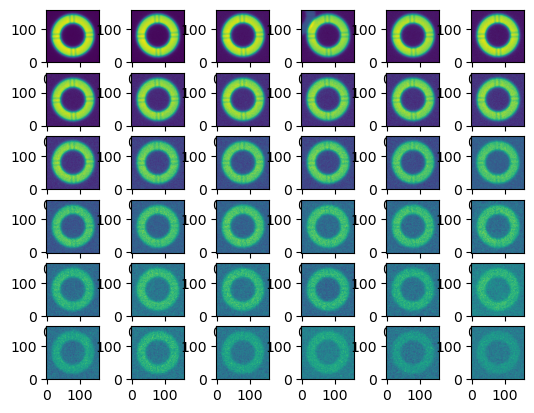

In [87]:
import numpy as np 
fig,axs = plt.subplots(6,6)

ax = np.ravel(axs)

for i  in range(len(ax)):
    stamp = donutStampsIntra[i]
    ax[i].imshow(stamp.stamp_im.image.array, origin='lower')
if len(donutStampsIntra)<len(ax):
    for i in range(len(donutStampsIntra), len(ax)):
        ax[i].axis('off')
        

We used `donutSelector.useCustomMagLimit: True` to provide as many donuts as possible.

## Run the pipeline from donut detection to Zernikes

The pipeline yaml contains:


    # Here we specify the corresponding instrument for the data we
    # will be using.
    instrument: lsst.obs.lsst.LsstComCamSim
    
    # Then we can specify each task in our pipeline by a name
    # and then specify the class name corresponding to that task
    tasks:
      generateDonutDirectDetectTask:
        class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
        config:
          donutSelector.useCustomMagLimit: True
      cutOutDonutsScienceSensorGroupTask:
        class: lsst.ts.wep.task.cutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTask
        config:
          donutStampSize: 160
          initialCutoutPadding: 40
          python: |
            from lsst.ts.wep.task.pairTask import GroupPairer
            config.pairer.retarget(GroupPairer)
      calcZernikesTask:
        class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
        config:
          python: |
            from lsst.ts.wep.task import  EstimateZernikesDanishTask
            config.estimateZernikes.retarget(EstimateZernikesDanishTask)
      aggregateZernikeTablesTask: lsst.donut.viz.AggregateZernikeTablesTask
      aggregateDonutTablesTask: lsst.donut.viz.AggregateDonutTablesTask
      aggregateAOSVisitTableTask: lsst.donut.viz.AggregateAOSVisitTableTask
      plotAOSTask: lsst.donut.viz.PlotAOSTask
      aggregateDonutStampsTask: lsst.donut.viz.AggregateDonutStampsTask
      plotDonutTask: lsst.donut.viz.PlotDonutTask
            
(`config.estimateZernikes.retarget(EstimateZernikesDanishTask)`  for the Danish version )

    allocateNodes.py -v -n 10 -c 64 -m 60:00:00 -q roma -g 1800 s3df --account rubin:developers
    
    bps submit site_bps.yaml \
    -b embargo_or4 \
    -i u/scichris/or4_night1_isr  \
    -o u/scichris/or4_night1_direct_danish_WEP_12-2_test \
    -p lsstComCamSimPipelineDirectToZkGroupingDanish.yaml \
    -d " exposure.observation_type='cwfs' and instrument='LSSTComCamSim'"

     
    bps submit site_bps.yaml \
    -b embargo_or4 \
    -i u/scichris/or4_night1_direct_stamps_WEP_12-2 \
    -o u/scichris/or4_night1_direct_tie_WEP_12-2_test \
    -p lsstComCamSimPipelineDirectToZkGrouping.yaml  \
    -d "exposure.observation_type='cwfs' and instrument='LSSTComCamSim'"
    

## Compare Danish and TIE fit results:

We load the results from butler and ensure that there is the same number of  Zernike estimates  from Danish as TIE. The data product that is equivalent to `zernikeEstimateAvg` is `aggregateZernikesAvg`:

In [279]:
butler = dafButler.Butler('embargo_or4')

In [282]:
butler.registry.queryDatasetTypes('*donut*')

[DatasetType('donutStampsExtraVisit', {band, instrument, day_obs, physical_filter, visit}, StampsBase),
 DatasetType('donutPlot', {band, instrument, day_obs, physical_filter, visit}, Plot),
 DatasetType('donutStampsExtra', {band, instrument, day_obs, detector, physical_filter, visit}, StampsBase),
 DatasetType('donutCatalog', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame),
 DatasetType('donutStampsIntraVisit', {band, instrument, day_obs, physical_filter, visit}, StampsBase),
 DatasetType('donutStampsIntra', {band, instrument, day_obs, detector, physical_filter, visit}, StampsBase),
 DatasetType('donutPlotExtra', {band, instrument, day_obs, physical_filter, visit}, Plot),
 DatasetType('donutsIntraQuality', {band, instrument, day_obs, detector, physical_filter, visit}, DataFrame),
 DatasetType('donutPlotIntra', {band, instrument, day_obs, physical_filter, visit}, Plot),
 DatasetType('donutsExtraQuality', {band, instrument, day_obs, detector, physical_filter, vi

In [283]:
method='tie'
collection = f'u/scichris/or4_night1_direct_{method}_WEP_12-2_test'
dataRefs = butler.registry.queryDatasets('donutTable',collections=[collection]).expanded()


In [284]:
list(dataRefs)

[DatasetRef(DatasetType('donutTable', {band, instrument, day_obs, detector, physical_filter, visit}, AstropyQTable), {instrument: 'LSSTComCamSim', detector: 2, visit: 7024062500086, band: 'i', day_obs: 20240625, physical_filter: 'i_06'}, run='u/scichris/or4_night1_direct_stamps_WEP_12-2/20241024T214716Z', id=b1a1f84e-4ec5-4f64-a12e-b7a253a1e4de),
 DatasetRef(DatasetType('donutTable', {band, instrument, day_obs, detector, physical_filter, visit}, AstropyQTable), {instrument: 'LSSTComCamSim', detector: 4, visit: 7024062500107, band: 'i', day_obs: 20240625, physical_filter: 'i_06'}, run='u/scichris/or4_night1_direct_stamps_WEP_12-2/20241024T214716Z', id=f5990456-bb06-4922-9eae-b8b28a4556e7),
 DatasetRef(DatasetType('donutTable', {band, instrument, day_obs, detector, physical_filter, visit}, AstropyQTable), {instrument: 'LSSTComCamSim', detector: 3, visit: 7024062500074, band: 'i', day_obs: 20240625, physical_filter: 'i_06'}, run='u/scichris/or4_night1_direct_stamps_WEP_12-2/20241024T21471

In [260]:
butler = dafButler.Butler('embargo_or4')
dataRefsMethod={}
for method in ['tie', 'danish']:
    collection = f'u/scichris/or4_night1_direct_{method}_WEP_12-2_test'
    dataRefs = butler.registry.queryDatasets('aggregateZernikesAvg',collections=[collection]).expanded()
    dataRefsMethod[method]=dataRefs
assert len(list(dataRefsMethod['tie'])) == len(list(dataRefsMethod['danish'])) 


Load all results to a dictionary for quicker plotting:

In [199]:
# prepare  the dictionary
results = {}
for method in ['danish','tie']:
    results[method] = {}
    for visit in np.unique(visits):
        results[method][visit] = {}

for ref in dataRefs:
    visit = ref.dataId.visit.id
    for method in results.keys():
        collection =  f'u/scichris/or4_night1_direct_{method}_WEP_12-2_test'
        results[method][visit] =    butler.get('aggregateZernikesAvg', dataId=ref.dataId, collections=[collection])
                                   

Plot the two methods for all detectors from a single visit: 

Text(0.05, 0.5, 'Zk value [microns]')

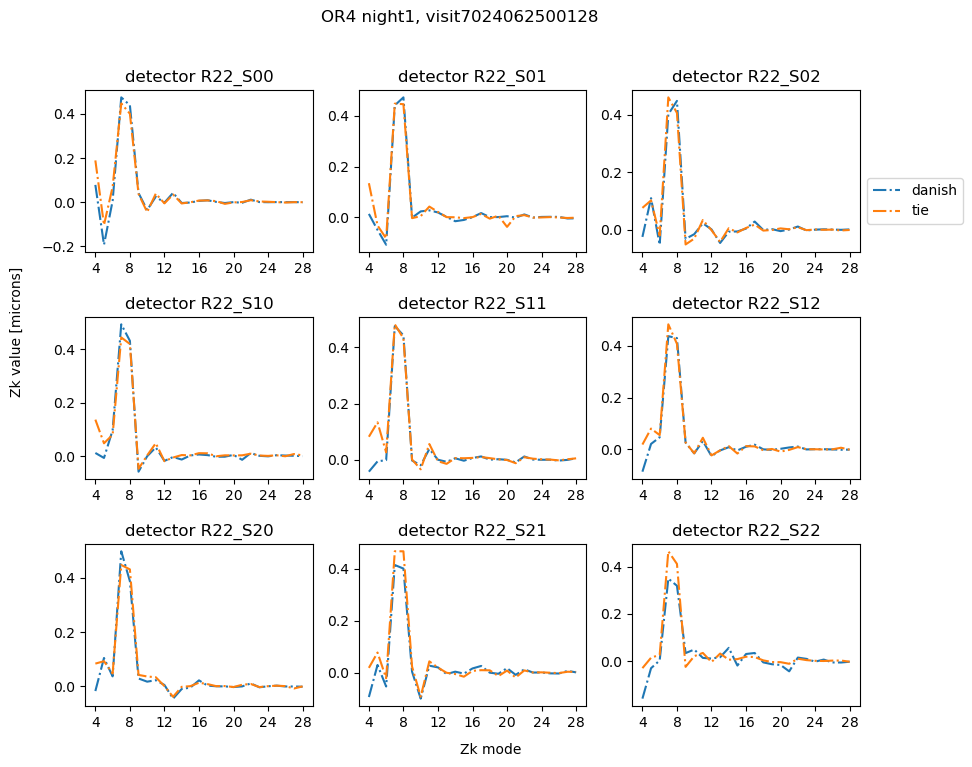

In [216]:
fig,axs = plt.subplots(3,3,figsize=(10,8))
ax = np.ravel(axs)
for method in results.keys():   
    aggregate = results[method][visit]
    i=0
    for row in aggregate.iterrows():
        ax[i].plot(np.arange(4,29),row[0], ls='-.', label=method)
        ax[i].set_title(f'detector {row[1]}')
        ax[i].set_xticks(range(4,29,4))
        i += 1 
ax[2].legend(bbox_to_anchor=[1.0,0.5])
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f'OR4 night1, visit{visit}')
fig.text(0.5,0.05, 'Zk mode')
fig.text(0.05,0.5, 'Zk value [microns]', rotation='vertical')

Show whether there is much difference between TIE and Danish for all defocal pairs (all `cwfs` visits):

Text(0.05, 0.5, '$\\Delta$ zk fit (Danish-TIE) [microns]')

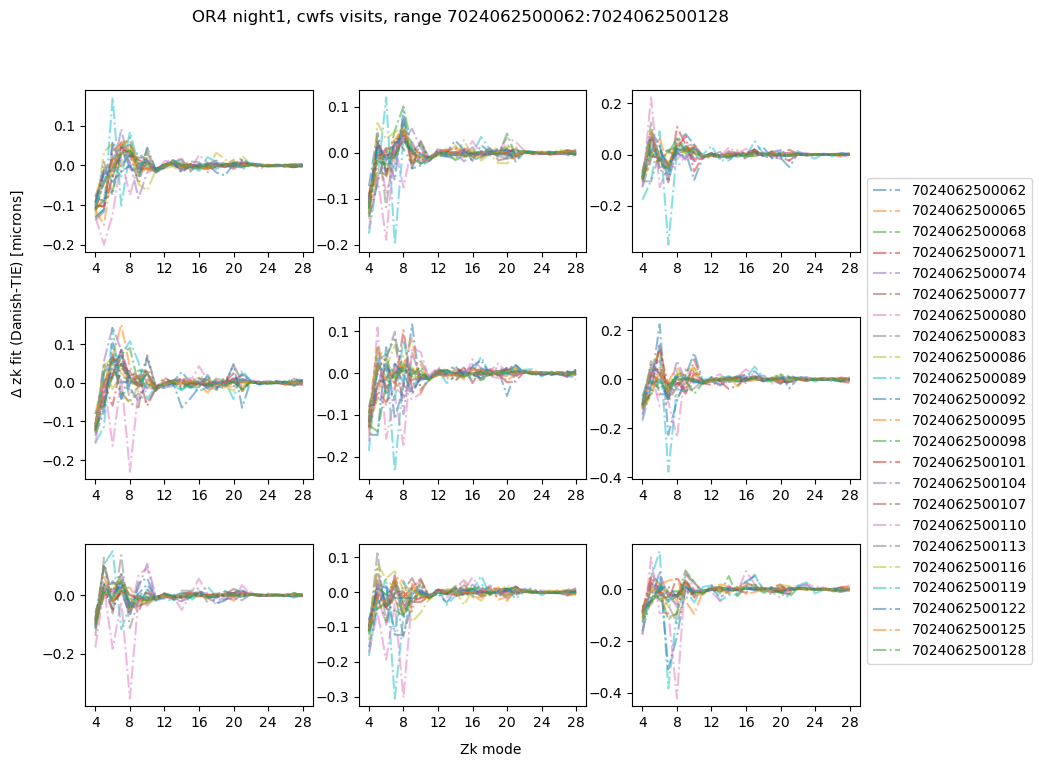

In [224]:
fig,axs = plt.subplots(3,3,figsize=(10,8))
ax = np.ravel(axs)
visits = results['tie'].keys()
for visit in visits:
    aggregateTie = results['tie'][visit]
    aggregateDanish = results['danish'][visit]

    for i in range(len(ax)):
        tieFit = aggregateTie['zk_CCS'][i]
        danishFit = aggregateDanish['zk_CCS'][i]
        diff = danishFit-tieFit   
        ax[i].plot(np.arange(4,29), diff, ls='-.', alpha=0.5, label=visit)
        ax[i].set_xticks(range(4,29,4))
ax[2].legend(bbox_to_anchor=[1.0,0.5])
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f'OR4 night1, cwfs visits, range {min(visits)}:{max(visits)}')
fig.text(0.5,0.05, 'Zk mode')
fig.text(0.05,0.5, f'$\Delta$ zk fit (Danish-TIE) [microns]', rotation='vertical')

If we plot that as absolute difference, we'll notice that most of the exposures have agreement within 0.1 microns:

In [261]:
aggregateTie

zk_CCS,detector,zk_OCS,zk_NW
float32[25],str7,float64[25],float64[25]
0.18919784 .. 0.00015242769,R22_S00,0.189197838306427 .. 8.405120662224609e-05,0.189197838306427 .. -0.00025966620544112795
0.13475493 .. -0.0011628749,R22_S01,0.13475492596626282 .. -0.00042142421410974376,0.13475492596626282 .. 0.0025736883052389897
0.07596672 .. -0.0011089254,R22_S02,0.0759667232632637 .. -0.0002278078568375466,0.0759667232632637 .. 0.002923641406663616
0.13644072 .. 0.0024557423,R22_S10,0.1364407241344452 .. 0.00016356615501157812,0.1364407241344452 .. -0.007393741651773133
0.08204434 .. 0.0051306793,R22_S11,0.0820443406701088 .. 0.004404593229199294,0.0820443406701088 .. -0.00449221125978501
0.018825157 .. -0.00096371834,R22_S12,0.01882515661418438 .. -0.0028238495948088257,0.01882515661418438 .. -0.004539672330564466
0.083931714 .. 0.0002349342,R22_S20,0.08393171429634094 .. 0.002448652919578486,0.08393171429634094 .. 0.005853089412027162
0.019332923 .. 0.0040239575,R22_S21,0.019332922995090485 .. 0.002555495331675816,0.019332922995090485 .. -0.0059472960182408935
-0.030253189 .. -0.0031139317,R22_S22,-0.03025318868458271 .. -0.003595419790310482,-0.03025318868458271 .. 0.0002398709956781339


Text(0.05, 0.5, '|$\\Delta$ zk fit| (Danish-TIE) [microns]')

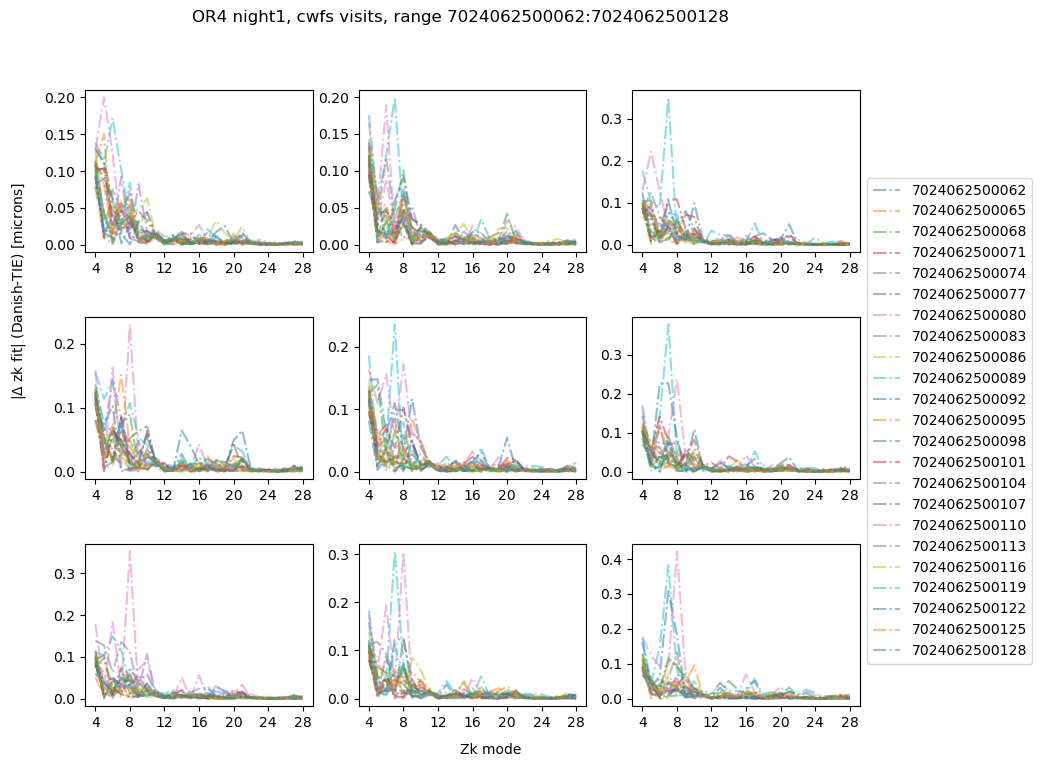

In [227]:
fig,axs = plt.subplots(3,3,figsize=(10,8))
ax = np.ravel(axs)
visits = results['tie'].keys()
for visit in visits:
    aggregateTie = results['tie'][visit]
    aggregateDanish = results['danish'][visit]

    for i in range(len(ax)):
        tieFit = aggregateTie['zk_CCS'][i]
        danishFit = aggregateDanish['zk_CCS'][i]
        diff = danishFit-tieFit   
        ax[i].plot(np.arange(4,29), abs(diff), ls='-.', alpha=0.5, label=visit)
        ax[i].set_xticks(range(4,29,4))
ax[2].legend(bbox_to_anchor=[1.0,0.5])
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.suptitle(f'OR4 night1, cwfs visits, range {min(visits)}:{max(visits)}')
fig.text(0.5,0.05, 'Zk mode')
fig.text(0.05,0.5, f'|$\Delta$ zk fit| (Danish-TIE) [microns]', rotation='vertical')



We can plot the differences for a single detector interactively so that it's easier to focus on an individual visit. Here we color-coded by the value of the RMS difference between TIE and Danish fit result:

In [255]:
output_notebook()
visits = list(results['danish'].keys())
palette = viridis(len(visits))
# plot a single detector 
i=0
ax = figure(width=800, height=500,title=f'OR4 night1, cwfs visits, range {min(visits)}:{max(visits)}, TIE vs Danish',
                    x_axis_label=r'$$ $$Zk  mode',
                    y_axis_label=r'|$$\Delta$$| zk fit (Danish-TIE) [microns]',)

# calculate rmss to sort 
rmss=[]
diffs = []
for visit in visits :
    aggregateTie = results['tie'][visit]
    aggregateDanish = results['danish'][visit]
    tieFit = aggregateTie['zk_CCS'][i] 
    danishFit = aggregateDanish['zk_CCS'][i]
    diff = danishFit-tieFit
    diffs.append(abs(diff))
    rmss.append(np.sqrt(np.mean(np.square(diff))))
    
args = np.argsort(rmss)
                
# first plot fit results 
for i in range(len(visits)):
    ax.line(np.arange(4,29),diffs[i], line_width=3,
            color=palette[args[i]],
            legend_label=str(visits[i])
           )
    
ax.legend.location = "top_right"
ax.legend.click_policy="mute"
ax.legend.ncols=2
show(ax)

Loading BokehJS ...

This allows us to interactively see which visits are most disparate between the two methods (in this case, `seqnum` 110).